## Load and Inspect Dataset

This section mounts Google Drive to access the project files and loads the `merged_dataset.csv` file into a pandas DataFrame. It then performs a quick inspection by printing the dataset dimensions, column names, and label distribution to verify that the data has been loaded correctly.

In [ ]:
# This Colab script mounts your Google Drive and loads 'merged_dataset.csv'
# directly into a pandas DataFrame for model training or testing.

# Mount and read the new merged file directly from Drive by its real path.
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd

file_path = '/content/drive/MyDrive/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv'  # <-- update to your exact path
assert os.path.exists(file_path), f"Not found: {file_path}"

df = pd.read_csv(file_path)

print("✅ Loaded:", file_path)
print("📋 Columns:", df.columns.tolist())
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# robust label count (handles 0,1 and 0.0,1.0)
label_counts = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int).value_counts().sort_index()
print("🔢 Label counts:\n", label_counts)

Mounted at /content/drive
✅ Loaded: /content/drive/MyDrive/ENPM703 Group 7 Project/Merged Enron Dataset/merged_dataset.csv
📋 Columns: ['subject', 'body', 'label']
📊 Shape: 145639 rows × 3 columns
🔢 Label counts:
 label
0    68452
1    77187
Name: count, dtype: int64


## Inspect Column Headers and Label Counts

This block performs a detailed inspection of the dataset structure and class balance. It prints the list of column headers and calculates the exact number of legitimate emails (Label 0) versus phishing emails (Label 1) to ensure the data is properly formatted and ready for analysis.

In [ ]:
# Print column headers and count total 0s and 1s in the 'label' column

# Column headers
print("📋 Column Headers:")
print(df.columns.tolist())
print("\n")

# Convert the label column safely to integers (handles 0.0/1.0 etc.)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# Count and sum
label_counts = df['label'].value_counts().sort_index()
total_zeros = label_counts.get(0, 0)
total_ones = label_counts.get(1, 0)

print("🔢 Label Counts:")
print(f"0 (OK emails): {total_zeros}")
print(f"1 (Phishing emails): {total_ones}")
print(f"📊 Total emails: {total_zeros + total_ones}")

📋 Column Headers:
['subject', 'body', 'label']


🔢 Label Counts:
0 (OK emails): 68452
1 (Phishing emails): 77187
📊 Total emails: 145639


## Stratified Train-Validation-Test Split

This step partitions the dataset into training (70%), validation (20%), and testing (10%) sets. It employs stratified sampling to preserve the ratio of legitimate to phishing emails in each subset, ensuring that the model is trained and evaluated on representative data distributions. A random seed is set to guarantee reproducibility of the splits.

In [ ]:

from sklearn.model_selection import train_test_split

# set a random seed for repeatability
RANDOM_SEED = 42

# ensure labels are integers
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

# split data: 70% train, 30% temp
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])

# split temp into 20% validation and 10% test (relative to full dataset)
val_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=RANDOM_SEED, stratify=temp_df['label'])

# print summaries
print("Training set size:", len(train_df))
print(train_df['label'].value_counts().sort_index(), "\n")

print("Validation set size:", len(val_df))
print(val_df['label'].value_counts().sort_index(), "\n")

print("Testing set size:", len(test_df))
print(test_df['label'].value_counts().sort_index())

Training set size: 101947
label
0    47916
1    54031
Name: count, dtype: int64 

Validation set size: 29128
label
0    13691
1    15437
Name: count, dtype: int64 

Testing set size: 14564
label
0    6845
1    7719
Name: count, dtype: int64


## Text Preprocessing and Vectorization

This step prepares the email content for the deep learning model. First, the subject and body of each email are concatenated into a single text string. Then, a TensorFlow `TextVectorization` layer is configured to standardize the text, tokenize it, and map tokens to integers. The layer is adapted to the training data to build the vocabulary, and finally, the training, validation, and test sets are converted into fixed-length integer sequences suitable for the LSTM-GRU model.

In [ ]:
import tensorflow as tf

# Combine subject + body into one text input (stacked LSTM->GRU will use this)
train_text = (train_df["subject"].fillna("") + " " + train_df["body"].fillna("")).astype(str)
val_text   = (val_df["subject"].fillna("") + " " + val_df["body"].fillna("")).astype(str)
test_text  = (test_df["subject"].fillna("") + " " + test_df["body"].fillna("")).astype(str)

MAX_TOKENS = 40000
SEQ_LEN    = 256

text_vec = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    standardize="lower_and_strip_punctuation",
)

text_vec.adapt(train_text)

X_train = text_vec(train_text)
X_val   = text_vec(val_text)
X_test  = text_vec(test_text)

vocab_size_stacked = len(text_vec.get_vocabulary())
print("Vocabulary size:", vocab_size_stacked)


## Build Stacked LSTM-GRU Model

This section constructs the deep learning model architecture designed for email classification. It starts with an `Embedding` layer to learn dense vector representations of words. The core of the model consists of a stacked Recurrent Neural Network (RNN) configuration: an `LSTM` layer (Long Short-Term Memory) followed by a `GRU` layer (Gated Recurrent Unit). This hybrid approach captures both long-term dependencies and local patterns in the text sequences. Finally, fully connected `Dense` layers with `Dropout` are added for classification and regularization, and the model is compiled with the Adam optimizer and binary cross-entropy loss.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

embed_dim = 128

inp = Input(shape=(SEQ_LEN,), name="text_input")
x = Embedding(vocab_size_stacked, embed_dim, name="embed")(inp)

# Key part: stacked LSTM -> GRU
x = LSTM(128, return_sequences=True, dropout=0.2, name="lstm")(x)
x = GRU(64, dropout=0.2, name="gru")(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)

stacked_model = Model(inp, out, name="Stacked_LSTM_to_GRU")

stacked_model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

stacked_model.summary()


Model: "Stacked_LSTM_to_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed (Embedding)               │ (None, 256, 128)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,297,281 (20.21 MB)

 Trainable params: 5,297,281 (20.21 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

This section executes the model training process. It defines two critical callbacks: `EarlyStopping` to prevent overfitting by halting training when the validation AUC stops improving, and `ModelCheckpoint` to save the best version of the model during training. The model is then trained on the training set for up to 15 epochs with a batch size of 64, while being evaluated on the validation set at the end of each epoch.

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_stacked_lstm_gru.keras", monitor="val_auc", mode="max", save_best_only=True),
]

hist2 = stacked_model.fit(
    X_train, train_df["label"].values,
    validation_data=(X_val, val_df["label"].values),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.7425 - auc: 0.8236 - loss: 0.4498 - precision: 0.7527 - recall: 0.7779 - val_accuracy: 0.9831 - val_auc: 0.9981 - val_loss: 0.0487 - val_precision: 0.9871 - val_recall: 0.9810
Epoch 2/15
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.9888 - auc: 0.9986 - loss: 0.0351 - precision: 0.9887 - recall: 0.9901 - val_accuracy: 0.9867 - val_auc: 0.9984 - val_loss: 0.0381 - val_precision: 0.9922 - val_recall: 0.9827
Epoch 3/15
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9955 - auc: 0.9996 - loss: 0.0143 - precision: 0.9953 - recall: 0.9961 - val_accuracy: 0.9882 - val_auc: 0.9980 - val_loss: 0.0379 - val_precision: 0.9915 - val_recall: 0.9861
Epoch 4/15
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9979 - auc: 0.9997 - loss: 0.0071 - precision: 0.9976 - recall: 0.9984 - val_accuracy: 0.9877 - val_auc: 0.9961 - val_loss: 0.0502 - val_precision: 0.9921 - val_recall: 0.9846
Epoch 5/15
1593/

## Model Evaluation on Test Set

This section assesses the model's performance on the held-out test dataset. It generates probability predictions for each email and converts them into binary class labels using a standard threshold of 0.5. Key performance metrics—including overall accuracy, a confusion matrix to visualize correct and incorrect predictions, and a detailed classification report containing precision, recall, and F1-scores—are computed and displayed to provide a comprehensive view of the model's effectiveness.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

proba = stacked_model.predict(X_test, verbose=0).ravel()
pred  = (proba >= 0.5).astype(int)

print("Test Accuracy:", accuracy_score(test_df["label"].values, pred))
print("Confusion Matrix:\n", confusion_matrix(test_df["label"].values, pred))
print("Classification Report:\n")
print(classification_report(test_df["label"].values, pred, digits=4))


Test Accuracy: 0.986061521560011
Confusion Matrix:
 [[6764   81]
 [ 122 7597]]
Classification Report:

              precision    recall  f1-score   support

           0     0.9823    0.9882    0.9852      6845
           1     0.9895    0.9842    0.9868      7719

    accuracy                         0.9861     14564
   macro avg     0.9859    0.9862    0.9860     14564
weighted avg     0.9861    0.9861    0.9861     14564



## Separate Text Vectorization for Subject and Body

This section prepares the data for models that treat the email subject and body as distinct inputs. It initializes two separate `TextVectorization` layers—one for the subject line (capped at 50 tokens) and one for the email body (capped at 200 tokens). After handling missing values, the layers are adapted to the training data to build their respective vocabularies. Finally, the training, validation, and test sets are vectorized into integer sequences, ready for multi-input model architectures.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

# 2. Define constants
vocab_size = 20000
max_sequence_length_subject = 50
max_sequence_length_body = 200
embedding_dim = 128

# 3. Instantiate a TextVectorization layer for 'subject'
vectorize_subject_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length_subject
)

# 4. Instantiate a TextVectorization layer for 'body'
vectorize_body_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length_body
)

# Handle potential NaN values by converting to empty strings before adapting
train_df['subject'] = train_df['subject'].fillna('')
train_df['body'] = train_df['body'].fillna('')
val_df['subject'] = val_df['subject'].fillna('')
val_df['body'] = val_df['body'].fillna('')
test_df['subject'] = test_df['subject'].fillna('')
test_df['body'] = test_df['body'].fillna('')

# 5. Adapt vectorize_subject_layer to the 'subject' column of the train_df DataFrame
vectorize_subject_layer.adapt(train_df['subject'].values)

# 6. Adapt vectorize_body_layer to the 'body' column of the train_df DataFrame
vectorize_body_layer.adapt(train_df['body'].values)

# 7. Apply vectorize_subject_layer to subject columns
train_subjects_vectorized = vectorize_subject_layer(train_df['subject'].values).numpy()
val_subjects_vectorized = vectorize_subject_layer(val_df['subject'].values).numpy()
test_subjects_vectorized = vectorize_subject_layer(test_df['subject'].values).numpy()

# 8. Apply vectorize_body_layer to body columns
train_bodies_vectorized = vectorize_body_layer(train_df['body'].values).numpy()
val_bodies_vectorized = vectorize_body_layer(val_df['body'].values).numpy()
test_bodies_vectorized = vectorize_body_layer(test_df['body'].values).numpy()

print(f"✅ TextVectorization layers created and adapted.")
print(f"Shape of train_subjects_vectorized: {train_subjects_vectorized.shape}")
print(f"Shape of train_bodies_vectorized: {train_bodies_vectorized.shape}")
print(f"Shape of val_subjects_vectorized: {val_subjects_vectorized.shape}")
print(f"Shape of val_bodies_vectorized: {val_bodies_vectorized.shape}")
print(f"Shape of test_subjects_vectorized: {test_subjects_vectorized.shape}")
print(f"Shape of test_bodies_vectorized: {test_bodies_vectorized.shape}")


✅ TextVectorization layers created and adapted.
Shape of train_subjects_vectorized: (101947, 50)
Shape of train_bodies_vectorized: (101947, 200)
Shape of val_subjects_vectorized: (29128, 50)
Shape of val_bodies_vectorized: (29128, 200)
Shape of test_subjects_vectorized: (14564, 50)
Shape of test_bodies_vectorized: (14564, 200)


## Final Evaluation of Stacked LSTM-GRU Model

This section performs a conclusive evaluation of the trained Stacked LSTM-GRU model on the test set. By generating predictions and comparing them against true labels, it outputs the final accuracy, confusion matrix, and classification report. This step serves as the definitive measure of the model's generalization performance before deployment or comparison with other architectures.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

print("Final evaluation on test set (Stacked LSTM → GRU)")

proba = stacked_model.predict(X_test, verbose=0).ravel()
pred  = (proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(test_df["label"].values, pred))
print("Confusion Matrix:\n", confusion_matrix(test_df["label"].values, pred))
print("Classification Report:\n")
print(classification_report(test_df["label"].values, pred, digits=4))


Final evaluation on test set (Stacked LSTM → GRU)
Accuracy: 0.986061521560011
Confusion Matrix:
 [[6764   81]
 [ 122 7597]]
Classification Report:

              precision    recall  f1-score   support

           0     0.9823    0.9882    0.9852      6845
           1     0.9895    0.9842    0.9868      7719

    accuracy                         0.9861     14564
   macro avg     0.9859    0.9862    0.9860     14564
weighted avg     0.9861    0.9861    0.9861     14564



## Visualize Training History

This block defines and executes a utility function, `plot_training_curves`, to visualize the model's learning progress. It generates two plots: one for accuracy and one for loss (binary cross-entropy) over the training epochs. Comparing the training and validation curves helps identify overfitting (where training improves but validation degrades) or underfitting patterns.

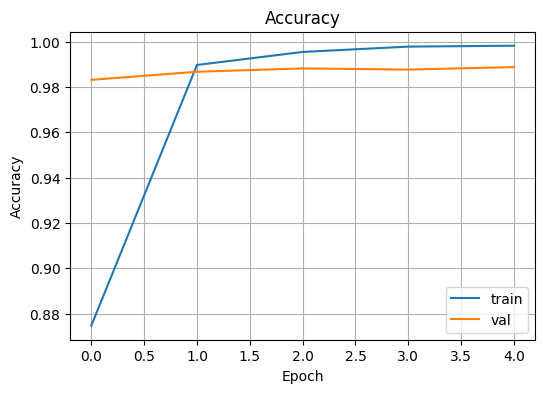

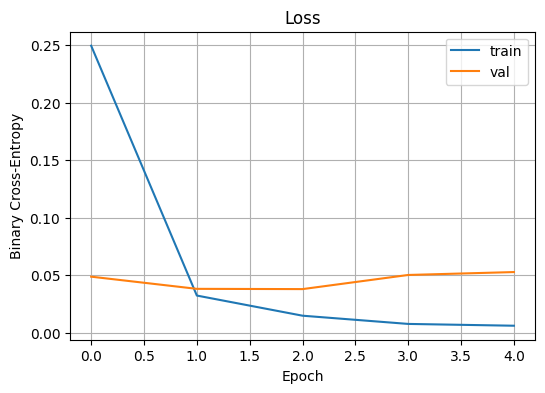

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    hist = history.history
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train")
    plt.plot(hist["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Binary Cross-Entropy"); plt.legend(); plt.grid(True)
    plt.show()

plot_training_curves(hist2)


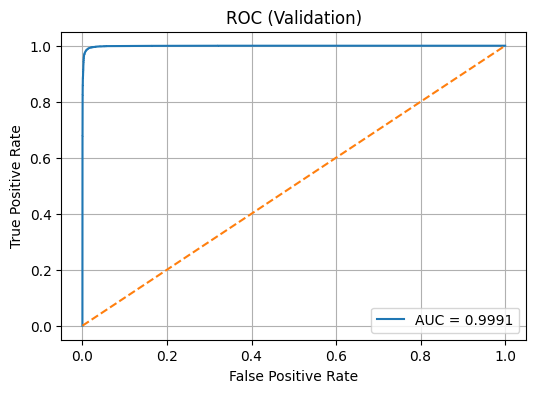

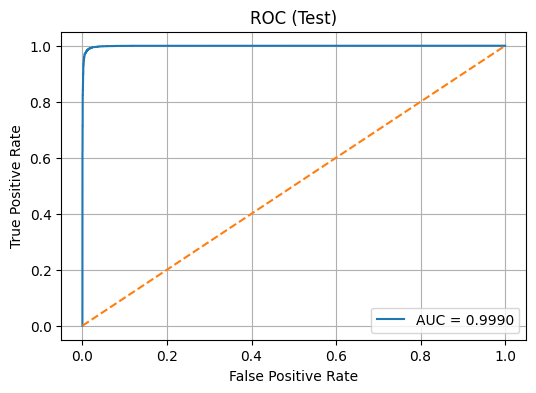

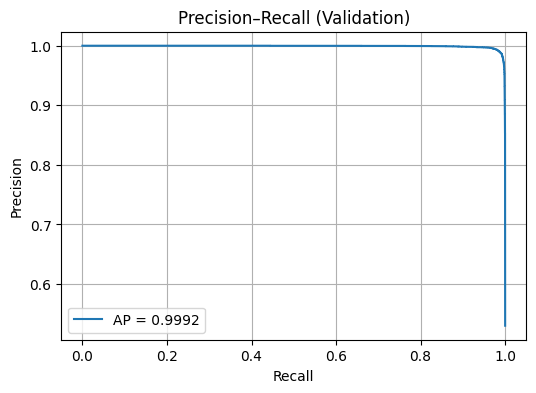

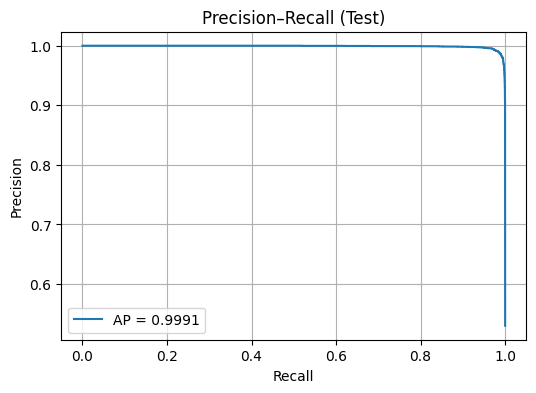

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

def proba_preds(model, X):
    return model.predict(X, verbose=0).ravel()

# Probabilities
val_proba  = proba_preds(stacked_model, X_val)
test_proba = proba_preds(stacked_model, X_test)

y_val  = val_df["label"].values
y_test = test_df["label"].values

# ROC
def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.grid(True)
    plt.show()

plot_roc(y_val, val_proba,  "ROC (Validation)")
plot_roc(y_test, test_proba, "ROC (Test)")

# Precision–Recall
def plot_pr(y_true, y_score, title):
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(r, p, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.legend(loc="lower left"); plt.grid(True)
    plt.show()

plot_pr(y_val,  val_proba,  "Precision–Recall (Validation)")
plot_pr(y_test, test_proba, "Precision–Recall (Test)")


In [ ]:
import pickle
model.save("lstm_gru_best.keras")
with open("subject_vectorizer.pkl","wb") as f: pickle.dump(vectorize_subject_layer, f)
with open("body_vectorizer.pkl","wb") as f: pickle.dump(vectorize_body_layer, f)

# Load later:
# model = tf.keras.models.load_model("lstm_gru_best.keras")
# vectorize_subject_layer = pickle.load(open("subject_vectorizer.pkl","rb"))
# vectorize_body_layer    = pickle.load(open("body_vectorizer.pkl","rb"))


## Cross-Dataset Generalization Check

This section tests the model's robustness by evaluating it on a completely separate dataset (e.g., a Kaggle Phishing Dataset). It loads the external data, applies the *existing* text vectorization (without retraining or re-adapting the tokenizer), and generates predictions using the pre-trained Stacked LSTM-GRU model. This "out-of-distribution" test helps determine if the model has learned generalizable features or if it has merely memorized specific patterns from the training source.

In [ ]:
# ===============================
# Cross-Dataset Evaluation
# ===============================

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load external dataset (same schema: subject, body, label)
external_path = "/content/drive/MyDrive/ENPM703 Group 7 Project/Separate Kaggle Test Dataset/phishing_legit_dataset_merged_columns.csv"  # <-- UPDATE THIS

external_df = pd.read_csv(external_path)

# Basic cleanup (DO NOT adapt or retrain anything)
external_df["subject"] = external_df["subject"].fillna("").astype(str)
external_df["body"]    = external_df["body"].fillna("").astype(str)
external_df["label"]   = pd.to_numeric(external_df["label"], errors="coerce")

# Drop invalid labels safely
external_df = external_df.dropna(subset=["label"]).copy()
external_df["label"] = external_df["label"].astype(int)

# Sanity check
assert set(external_df["label"].unique()).issubset({0, 1}), "Non-binary labels detected"

print("External dataset shape:", external_df.shape)
print("Label distribution:\n", external_df["label"].value_counts().sort_index())

# 2. Apply SAME preprocessing as training (NO adapt)
external_text = (external_df["subject"] + " " + external_df["body"]).astype(str)
X_external = text_vec(external_text)
y_external = external_df["label"].values

# 3. Evaluate using the FINAL trained model (stacked LSTM → GRU)
proba_external = stacked_model.predict(X_external, verbose=0).ravel()
pred_external  = (proba_external >= 0.5).astype(int)

print("\n=== Cross-Dataset Evaluation Results ===")
print("Accuracy:", accuracy_score(y_external, pred_external))
print("\nConfusion Matrix:\n", confusion_matrix(y_external, pred_external))
print("\nClassification Report:\n")
print(classification_report(y_external, pred_external, digits=4))


External dataset shape: (10000, 3)
Label distribution:
 label
0    4000
1    6000
Name: count, dtype: int64

=== Cross-Dataset Evaluation Results ===
Accuracy: 0.9335

Confusion Matrix:
 [[3974   26]
 [ 639 5361]]

Classification Report:

              precision    recall  f1-score   support

           0     0.8615    0.9935    0.9228      4000
           1     0.9952    0.8935    0.9416      6000

    accuracy                         0.9335     10000
   macro avg     0.9283    0.9435    0.9322     10000
weighted avg     0.9417    0.9335    0.9341     10000

